<h1><center><font size="6">Post-Augmentation Modeling Notebook</font></center></h1>

# Contents

- <a href='#1'>Importing Packages</a>  
- <a href='#2'>Augmentations through ImageDataGenerator</a>
    - <a href='#21'>Generating the Datasets</a>   
    - <a href='#22'>Constructing and Compiling the Model</a>   
    - <a href='#23'>Defining Callbacks</a>   
- <a href='#4'>VGG16-based CNN Model</a>
    - <a href='#41'>Generating the Datasets</a>   
    - <a href='#42'>Constructing the Model</a>   
    - <a href='#43'>Compiling the Model</a>   
    - <a href='#44'>Defining Callbacks</a>   
    - <a href='#45'>Training the Model</a>   
    - <a href='#46'>Evaluating the Model</a>
    - <a href='#47'>Predicting on Holdout Set</a>    
    - <a href='#48'>Saving the Model</a>  
- <a href='#5'>Final Simplified CNN Model</a>
    - <a href='#51'>Generating the Datasets</a>   
    - <a href='#52'>Constructing the Model</a>   
    - <a href='#53'>Compiling the Model</a>   
    - <a href='#54'>Defining Callbacks</a>   
    - <a href='#55'>Training the Model</a>   
    - <a href='#56'>Evaluating the Model</a>
    - <a href='#57'>Saving the Model</a>    
    - <a href='#58'>Predicting on Holdout Set</a>
    - <a href='#59'>Confusion Matrix</a>


# <a id='1'>Importing Packages</a>

In [2]:
# importing packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import datetime

import warnings
warnings.simplefilter("ignore")

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPool2D, GlobalAveragePooling2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.metrics import AUC, Precision, Recall

from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

from utils import *

%reload_ext autoreload
%autoreload 2


# <a id='2'>Augmentation through ImageDataGenerator</a>


## <a id='21'>Generating the Datasets</a>
 

In [2]:
# generating augmentations through ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255, 
                                   rotation_range = 40, 
                                   width_shift_range = 0.2, 
                                   height_shift_range = 0.2, 
                                   zoom_range = 0.1, 
                                   horizontal_flip = True,
                                   vertical_flip = True)

# assigning paths
train_folder = '../split/train_imb'
val_folder = '../split/val'
test_folder = '../split/test2'

# generating datasets for training, validation, and testing
train_generator = train_datagen.flow_from_directory(train_folder, 
                                                    target_size=(224, 224), 
                                                    batch_size = 16,
                                                    class_mode = 'binary',
                                                    seed = 42)
val_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(val_folder,
                                                                       target_size=(224, 224),
                                                                       batch_size = 16,
                                                                       class_mode = 'binary',
                                                                       seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(test_folder,
                                                                        target_size = (224, 224),
                                                                        batch_size = 1,
                                                                        class_mode = 'binary',
                                                                        shuffle=False)

Found 26500 images belonging to 2 classes.
Found 3765 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


## <a id='22'>Constructing and Compiling the Model</a>


In [3]:
# create model
def create_model(input_shape):
    return Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Flatten(),
        Dense(units=4096, activation='relu'),
        Dense(units=1, activation='sigmoid')
        ])

model = create_model((224, 224, 3))

# compile model
model.compile(loss = 'binary_crossentropy',
              optimizer = Adam(lr=0.01),
              metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])

## <a id='23'>Defining Callbacks</a>


In [4]:
# define callbacks
filepath = '../models/CNN_v1.h5'
earlyStopping = EarlyStopping(monitor = 'val_loss', 
                              verbose = 1, 
                              mode = 'min', 
                              patience = 4)
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')

## <a id='24'>Training the Model</a>


In [ ]:
# train model
history = model.fit_generator(generator = train_generator,
                             epochs = 20,
                             steps_per_epoch = len(train_generator),
                             callbacks = [earlyStopping, mcp_save],
                             validation_data = val_generator,
                             validation_steps = len(val_generator))

# <a id='4'>VGG16-based CNN Model</a>

## <a id='41'>Generating the Datasets</a>
 

In [14]:
# create datasets for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='42'>Constructing the Model</a>


In [6]:
# build model similar to VGG16
def cnn_model_1(input_shape):
    return Sequential([
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),  
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'), 
        Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPool2D(pool_size=(2, 2), strides=(2, 2)),   
        Flatten(),
        Dense(units=4096, activation='relu'),
        Dense(units=1, activation='sigmoid')
        ])

model2 = cnn_model_1((256, 256, 3))

In [7]:
# compile model
model2.compile(optimizer = Adam(lr=0.001), 
               loss = 'binary_crossentropy',
               metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])

In [8]:
# Define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_cnn1b/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_cnn1b/log.csv')
log_dir = "../logs/log_cnn1b/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## <a id='45'>Training the Model</a>

In [ ]:
# train model
history2 = model2.fit_generator(generator = train_generator,
                               steps_per_epoch = STEP_SIZE_TRAIN,
                               validation_data = valid_generator,
                               validation_steps = STEP_SIZE_VALID,
                               epochs = 20,
                               callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

## Loading Best Model

In [11]:
model_2 = load_model('../logs/log_cnn1a/model.16-0.15.hdf5')

## <a id='46'>Evaluating the Model</a>


In [7]:
history2 = pd.read_csv("../logs/log_cnn1a/log.csv")
history2

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.871336,0.866554,0.735384,3.924863,0.001000,0.756297,0.681177,0.901596,0.882685,0.709019,0.413366,0.868421,0.323529
1,1,0.930832,0.960160,0.923713,0.219828,0.001000,0.911095,0.786855,0.930851,0.917790,0.787180,0.215068,0.784091,0.676471
2,2,0.893904,0.909665,0.829643,0.824269,0.001000,0.835810,0.691032,0.800532,0.510988,0.140549,17.107557,0.157143,0.107843
3,3,0.889361,0.902238,0.824960,0.446129,0.001000,0.874570,0.625691,0.873670,0.883537,0.649668,0.332140,1.000000,0.068627
4,4,0.908851,0.930173,0.870157,0.313404,0.001000,0.904724,0.691978,0.913564,0.892858,0.711126,0.250503,0.930233,0.392157
5,5,0.934496,0.961953,0.927704,0.189237,0.000500,0.913805,0.800983,0.926862,0.929291,0.822870,0.271090,1.000000,0.460784
6,6,0.936254,0.968932,0.938598,0.180079,0.000500,0.908904,0.814610,0.946809,0.943612,0.860561,0.170598,0.852273,0.735294
7,7,0.940944,0.971697,0.942351,0.162238,0.000500,0.930380,0.813153,0.948138,0.933778,0.842447,0.173439,0.970149,0.637255
8,8,0.946366,0.974992,0.950251,0.147226,0.000500,0.932331,0.836297,0.937500,0.937866,0.834188,0.210739,0.966102,0.558824
9,9,0.945780,0.976509,0.951264,0.145290,0.000500,0.931271,0.833846,0.942819,0.954959,0.864895,0.152427,0.871795,0.673267


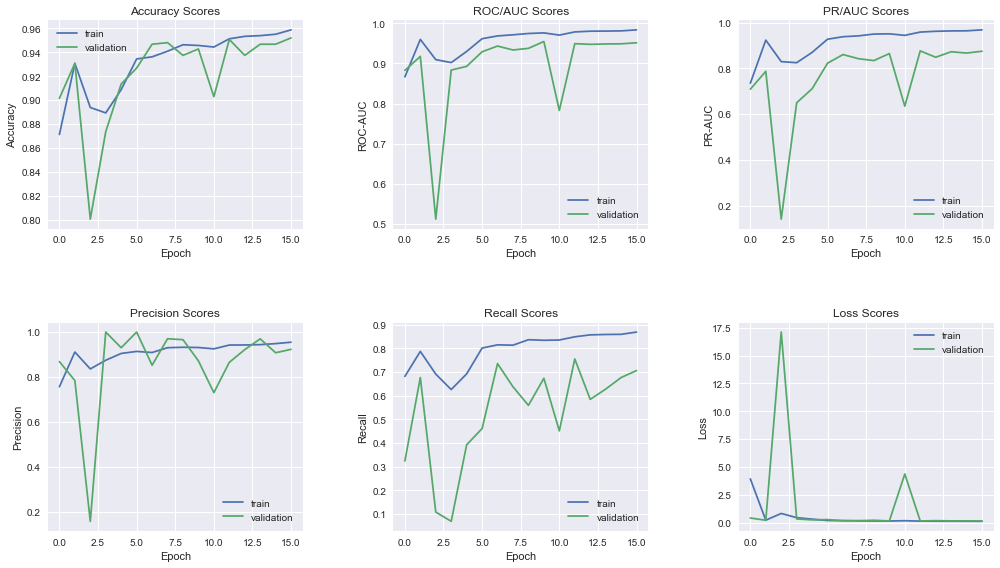

In [8]:
# evaluate model by displaying metrics with visualization
plt.style.use('seaborn')
sixplot2(history2, 'auc', 'val_auc', 'auc_1', 'val_auc_1', 'precision', 'val_precision', 'recall', 'val_recall')

In [9]:
# display metrics in dataframe
hist_df_2 = pd.DataFrame(history2.history)
hist_df_2

,loss,accuracy,auc,auc_1,precision,recall,val_loss,val_accuracy,val_auc,val_auc_1,val_precision,val_recall,lr
0,2.402366,0.885258,0.892163,0.946598,0.907561,0.945493,10.242761,0.625000,0.549842,0.891581,0.870968,0.664615,0.0010
1,0.234129,0.918230,0.953785,0.980451,0.929259,0.966115,0.267741,0.889628,0.910286,0.978655,0.960976,0.909231,0.0010
2,0.310886,0.912954,0.942698,0.975466,0.924511,0.964382,0.377229,0.855053,0.886344,0.975959,0.947195,0.881720,0.0010
3,0.227917,0.927755,0.962194,0.984146,0.938608,0.968425,0.247580,0.886968,0.934095,0.985889,0.965404,0.901538,0.0010
4,0.205663,0.935082,0.963374,0.984242,0.940445,0.976498,0.180013,0.934840,0.938650,0.987645,0.938686,0.989231,0.0010
5,0.402103,0.920721,0.945302,0.977060,0.925425,0.974403,0.260553,0.906915,0.901968,0.978769,0.942073,0.950769,0.0010
6,0.407393,0.904455,0.920073,0.961972,0.912176,0.967661,0.254619,0.909574,0.897278,0.977138,0.944954,0.950769,0.0010
7,0.189433,0.933030,0.958471,0.984338,0.931210,0.984796,0.233002,0.937500,0.915091,0.977548,0.940146,0.990769,0.0010
8,0.176037,0.936694,0.965738,0.986710,0.936607,0.983455,0.226174,0.908245,0.928748,0.983102,0.958926,0.933846,0.0010
9,0.146896,0.946073,0.975330,0.990558,0.945213,0.986333,0.230107,0.929521,0.914389,0.978137,0.933237,0.989231,0.0010


## <a id='47'>Predicting on Holdout Set</a>

In [15]:
# get testing accuracy and loss
test_generator.reset()
score = model_2.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]))
print("Precision: " + str(score[2]))
print("Recall: " + str(score[3]))
print("ROC-AUC: " + str(score[4]))
print("PR-AUC: " + str(score[5]))

753/753 [==============================] - 273s 362ms/step - loss: 0.1547 - accuracy: 0.9402 - auc: 0.9569 - auc_1: 0.8614 - precision: 0.8904 - recall: 0.6373
Loss: 0.15467676520347595
Accuracy: 0.9402390718460083
Precision: 0.9569138288497925
Recall: 0.8614485263824463
ROC-AUC: 0.8904109597206116
PR-AUC: 0.6372548937797546


753/753 [==============================] - 301s 400ms/step


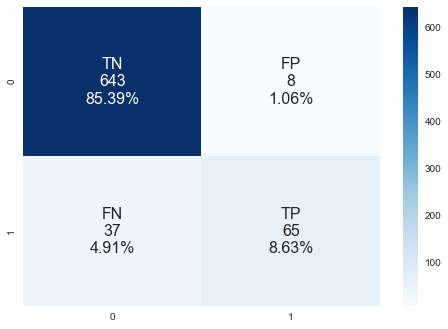

In [16]:
# visualization for confusion matrix
test_generator.reset()
pred2 = model_2.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred2 = pred2 > 0.5
make_confusion_matrix(y_true, y_pred2)

# <a id='5'>Simplified CNN Model</a>


## <a id='51'>Generating the Datasets</a>


In [3]:
# Set path for trasining testing and validation
# Data Generator for training, validation, and testing
train_fldr = '../sample/train'
val_fldr = '../sample/val'
test_fldr = '../sample/test'

train_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        train_fldr,
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
valid_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        val_fldr, 
        target_size = (256, 256),
        batch_size = 16,
        class_mode = 'binary',
        seed = 42)
test_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        test_fldr, 
        target_size = (256, 256),
        batch_size = 1,
        class_mode = 'binary',
        shuffle = False,
        seed = 42)

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n // valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n // test_generator.batch_size

Found 6840 images belonging to 2 classes.
Found 753 images belonging to 2 classes.
Found 753 images belonging to 2 classes.


## <a id='52'>Constructing the Model</a>


In [5]:
# construct model
def cnn2(input_shape):
    return Sequential([
        Conv2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape),
        Dropout(0.2),
        MaxPooling2D(pool_size=(3, 3)),
        Conv2D(filters=32, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=64, kernel_size=(2, 2), activation='relu', padding='same'),
        Dropout(0.2),
        MaxPool2D(pool_size=(2, 2)),
        Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
        Dropout(0.2), 
        MaxPool2D(pool_size=(3, 3)),
        Flatten(),
        Dense(units=32, activation='relu'),
        Dropout(0.25),     
        Dense(units=1, activation='sigmoid')
        ])

model_3 = cnn2((256, 256, 3))

In [6]:
# compile model
model_3.compile(optimizer = Adam(lr=0.001), 
                loss = 'binary_crossentropy',
                metrics = ['accuracy', AUC(), AUC(curve='PR'), Precision(), Recall()])

In [7]:
# define callbacks
lr_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                 patience = 3,
                                 verbose = 1,
                                 factor = 0.5,
                                 min_lr = 0.00001)
filepath = "../logs/log_cnn/model.{epoch:02d}-{val_loss:.2f}.hdf5"
mcp_save = ModelCheckpoint(filepath, 
                           verbose = 1, 
                           monitor = 'val_loss', 
                           mode = 'min')
csv_logger = CSVLogger('../logs/log_cnn/log.csv')
log_dir = "../logs/log_cnn/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_cb = TensorBoard(log_dir = log_dir,
                             histogram_freq = 1,
                             update_freq = 'batch')

## <a id='55'>Training the Model</a>


In [8]:
# train model
history_3 = model_3.fit_generator(generator = train_generator,
                                  steps_per_epoch = STEP_SIZE_TRAIN,
                                  validation_data = valid_generator,
                                  validation_steps = STEP_SIZE_VALID,
                                  epochs = 20,
                                  callbacks = [lr_reduction, mcp_save, tensorboard_cb, csv_logger])

Epoch 1/20
427/427 [==============================] - 1418s 3s/step - loss: 0.3305 - accuracy: 0.8809 - auc: 0.8590 - auc_1: 0.7767 - precision: 0.8550 - recall: 0.5864 - val_loss: 0.3206 - val_accuracy: 0.9282 - val_auc: 0.9306 - val_auc_1: 0.7864 - val_precision: 0.9000 - val_recall: 0.5294

Epoch 00001: saving model to ../logs/log_cnn/model.01-0.32.hdf5
Epoch 2/20
427/427 [==============================] - 1176s 3s/step - loss: 0.2056 - accuracy: 0.9311 - auc: 0.9452 - auc_1: 0.9112 - precision: 0.9132 - recall: 0.7816 - val_loss: 0.3337 - val_accuracy: 0.8843 - val_auc: 0.9009 - val_auc_1: 0.7638 - val_precision: 0.5486 - val_recall: 0.7822

Epoch 00002: saving model to ../logs/log_cnn/model.02-0.33.hdf5
Epoch 3/20
427/427 [==============================] - 1174s 3s/step - loss: 0.1808 - accuracy: 0.9365 - auc: 0.9600 - auc_1: 0.9347 - precision: 0.9124 - recall: 0.8208 - val_loss: 0.2716 - val_accuracy: 0.9322 - val_auc: 0.9517 - val_auc_1: 0.8188 - val_precision: 0.8923 - val_rec

## <a id='56'>Evaluating the Model</a>

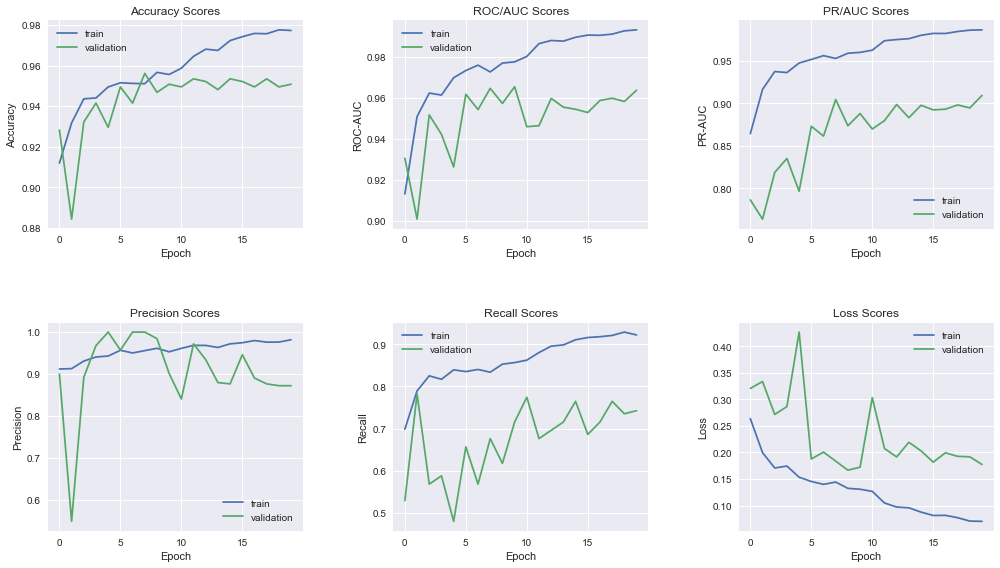

In [14]:
# create visualizations for training metrics
plt.style.use('seaborn')
history_3 = pd.read_csv("../logs/log_cnn/log.csv")
sixplot2(history_3, "auc", "val_auc", "auc_1", "val_auc_1", "precision", "val_precision", "recall", "val_recall")

In [15]:
# display dataframe of training metrics
history_3

,epoch,accuracy,auc,auc_1,loss,lr,precision,recall,val_accuracy,val_auc,val_auc_1,val_loss,val_precision,val_recall
0,0,0.911928,0.913179,0.864439,0.263593,0.001000,0.911930,0.698773,0.928191,0.930596,0.786420,0.320635,0.900000,0.529412
1,1,0.931712,0.950870,0.916413,0.199789,0.001000,0.912766,0.789571,0.884309,0.900922,0.763805,0.333677,0.548611,0.782178
2,2,0.943581,0.962325,0.937502,0.170861,0.001000,0.930796,0.825153,0.932181,0.951667,0.818818,0.271645,0.892308,0.568627
3,3,0.944021,0.961328,0.936306,0.174479,0.001000,0.940594,0.816953,0.941489,0.942225,0.835204,0.286461,0.967742,0.588235
4,4,0.949443,0.969801,0.947514,0.153441,0.001000,0.942798,0.839264,0.929521,0.926327,0.796602,0.426822,1.000000,0.480392
5,5,0.951495,0.973296,0.951716,0.145439,0.001000,0.956522,0.835272,0.949468,0.961742,0.873094,0.187795,0.957143,0.656863
6,6,0.951202,0.975916,0.956198,0.139993,0.001000,0.950173,0.840269,0.941489,0.954268,0.861502,0.200694,1.000000,0.568627
7,7,0.951055,0.972611,0.952900,0.144300,0.001000,0.955696,0.833742,0.956117,0.964608,0.904582,0.183784,1.000000,0.676471
8,8,0.956624,0.976928,0.959022,0.132494,0.001000,0.961299,0.852851,0.946809,0.957270,0.873663,0.166702,0.984375,0.617647
9,9,0.955598,0.977511,0.960046,0.130827,0.001000,0.952933,0.856530,0.950798,0.965407,0.888076,0.172384,0.901235,0.715686


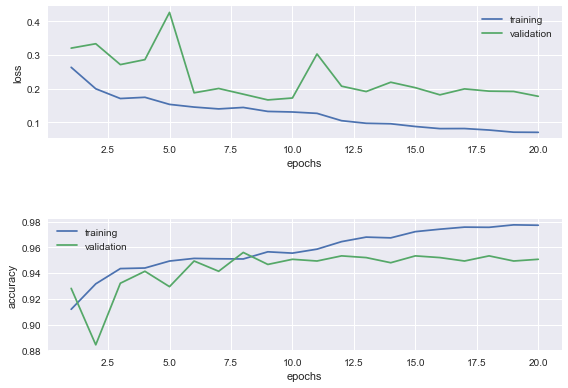

In [16]:
# plot accuracy and loss visualizations
plt.style.use('seaborn')
train_val_metrics2(20, history_3)

## Loading Best Model

In [18]:
model_3 = load_model('../logs/log_cnn/model.09-0.17.hdf5')

## <a id='58'>Predicting on Holdout Set</a>

753/753 [==============================] - 253s 336ms/step


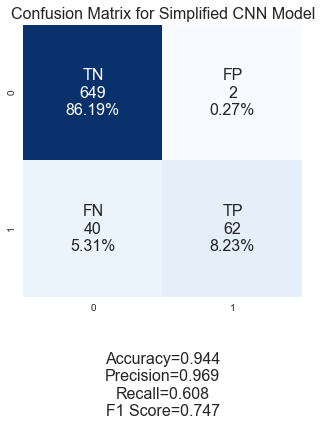

In [19]:
# display confusion matrix visualization
test_generator.reset()
pred_3 = model_3.predict_generator(test_generator, steps = STEP_SIZE_TEST, verbose = 1)
y_true = test_generator.classes
y_pred_3 = pred_3 > 0.5
cf = confusion_matrix(y_true, y_pred_3)
draw_confusion_matrix(cf, ['TN','FP','FN','TP'], (5, 5), "Confusion Matrix for Simplified CNN Model")

In [31]:
# get testing accuracy and loss
test_generator.reset()
score_3 = model_3.evaluate_generator(test_generator, verbose = 1)

print("Loss: " + str(score_3[0]))
print("Accuracy: " + str(score_3[1]))
print("Precision: " + str(score_3[2]))
print("Recall: " + str(score_3[3]))
print("ROC-AUC: " + str(score_3[4]))
print("PR-AUC: " + str(score_3[5]))

753/753 [==============================] - 124s 164ms/step - loss: 0.1862 - accuracy: 0.9402 - auc: 0.9380 - auc_1: 0.9857 - precision: 0.9647 - recall: 0.9662
loss: 0.18618255853652954
accuracy: 0.9402390718460083


# Analysis

The final CNN model is able not only to differentiate between the two classes, but is able to achieve high metrics across the board in terms of ROC-AUC and PR-AUC scores.